## Purpose

This notebook considers simluated example as in EX05. Here, we train coDeSurv with simulated ***out-of-distribution*** dataset (OOD). We define OOD as a set of covariates drawn from H1 whose pdf value is below 1% of the total sample (#10,000). 


## Covariates
We have a 2-dimensional covariate vector $\mathbf{x} = [x_1, x_2]$. The first three covariates, $x_1$, $x_2$ are drawn from a bivariate normal distribution.

- In **dataset H1**
$$\mathbf{x} \sim \text{Normal}(\mathbf{0}, I)$$


### Dataset

Given $\mathbf{x}_{i} \sim \text{H1}$, we categorize them into two datasets:

- **In-distribution dataset (ID)**
    $$
    \{\mathbf{x}_{i} \mid p_{H1}(x_i) > \alpha\}
    $$

- **Out-of-distribution dataset (OOD)**
    $$
    \{\mathbf{x}_{i} \mid p_{H1}(x_i) \leq \alpha\}
    $$

where $p_{H1}(\cdot)$ denotes probability density function (pdf) of (standard) bivariate normal as in H1, and $\alpha = P_{(0.01)}$, such that $P_{\beta}$ is defined as the $\beta$-quantile of the PDF of each covariate $x_{i} \sim \text{H1}$. Specifically, $D_{\beta}$ is the value for which:

$$
P(p_{H1}(x) \leq P_{\beta}) = \beta \quad \forall \mathbf{x} \sim P_{H1}
$$

In other words, the in-distribution dataset contains samples that likely to occur under covariate distribution H1, while the out-of-distribution dataset contains samples that rarely occur under H1.

### Data Generating Processes (DGP)

Given covariates, we generate time-to-event ($t$), following DGP:

- **DGP: G**
    $$ \ln Y = \sum_{j=1}^{2}w_{2j}x_{j} + w_{23}x_{1}x_{2} + w_{24}(x_{1} + x_{2} - 0.5)^{2} + \frac{Z}{3}, \quad Z \sim \text{Gumbel}(0, 1)$$
    
    - Here, the weights $\mathbf{w}_{2} = [0.2, 0.15, -0.1, -0.1]$.
    
## Methods

### Training & Test set

For training, we use the following dataset:

- ID_Train (D1): $\{t_{i}, \mathbf{x}_{i}\}_{i=1}^{1000}$ such that $t \sim G(\mathbf{x})$, $\mathbf{x} \sim P_{H1}$
- OOD_Train (D2): $\{t_{i}, \mathbf{x}_{i}: P_{H1}(\mathbf{x}_{i}) \leq P_{0.05}\}_{i=1}^{86}$ such that $t \sim G(\mathbf{x})$, $\mathbf{x} \sim P_{H2}$,


For testing, we use the test set created in EX05.

### Models

We train four models: the AFT Weibull model (AFT), DeSurv with consistency constraint (coDeSurv) and DeSurvs each of which is trained on D1 (D1_DeSurv) and D1&2 (DeSurv).

Note that:

	1.The AFT model is trained using only D1.
    2.DeSurv is trained trained on D1.
	3.coDeSurv is trained on both D1 (and D2).

### Training

To train coDeSurv, we carry out stochastic gradient descent using Adam to minimise the objective consisting of likelihood and (consistency) regularisation term:

$$\Big[\sum_{i: s_{i} = 1}\log p_{\boldsymbol{\theta}}(t_i|\mathbf{x}_i) + \sum_{i: s_i = 0}(\log (1- F_{\boldsymbol{\theta}}(t_{i}|\mathbf{x}_i))\Big] + \Big[\mathbb{E}_{\mathbf{x} \sim {\mathcal X_{D2}}} \mathbb{E}_{t \sim p_{\boldsymbol{\theta}}(t)} [ (F_\theta(t|\mathbf{x}) - \hat{F}(t|\mathbf{x}) )^2  ]\Big]$$

where $s \in \{0, 1\}$ denotes time-to-event indicator. The gradient of the regularisation term is estimated using the Score function estimator. 

Hyperparameters are set as follows: the number of epochs (300), the network architecture (1-hidden layer with 8 hidden units), and learning rate (0.001). When training coDeSurv, we pre-train the model for 20 epochs without regularisation term, and then introduce it to the training objective afterward.

### Evaluation

We test each model's predictive performance and consistency based on the test set (D1* and D2*). Predictive performance is measured in terms of log-likelihood and concordance index. The consistency is computed based on a Monte Carlo estimate of the following quantity: 

$$\mathbb{E}_{\mathbf{x} \sim {\mathcal X}} \mathbb{E}_{t \sim p_{\theta}(t)} [ (F_\theta(t|\mathbf{x}) - \hat{F}(t|\mathbf{x}) )^2  ]$$

where $\mathcal X \in \{\mathcal X_{D1*}, \mathcal X_{D2*}\}$

## Outcome

This notebook demonstrates that:

	1. coDeSurv's predicted survival curves are closer to the baseline model than D1_DeSurv on both D1 and D2.
    2. In D1, DeSurv (D1 & D2) results in a closer prediction than coDeSurv.
    3. DeSurv (D1 & D2) results in the best predictive performance in terms of LIK and C-index.
    
    

## Appendix

- **DGP G1**
    $$ \ln Y = \sum_{j=1}^{2} w_{1j} x_j + \frac{Z}{3}, \quad Z \sim \text{Gumbel}(0, 1) $$
    
    - Here, the weights $\mathbf{w}_1 = [0.2, 0.15]$.

**Note: In the end, we didn't simulate time-to-events from G1. Given t ~ G1, baseline model's predictive performance is more accurate in D2 than D1 even if it is trained only on D1.**

In [1]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import tqdm as tq
import pickle


from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.functional import softplus, softmax


from torch.distributions import Distribution
from scipy.optimize import root_scalar

from lifelines import WeibullAFTFitter, KaplanMeierFitter

from sksurv.metrics import concordance_index_censored

from typing import Union, List, Tuple

from model.coDeSurv import ConsistentDeSurv
from model.DeSurv import DeSurv
from model.utils import F_theta

## Simulating data

In [2]:
class DGP:
    """
    Weibull Accelerated Failure Time (AFT) model for generating synthetic data.

    Methods:
        gumbel_samples(N: int) -> np.ndarray:
            Generate Gumbel(0,1) samples.
        
        generate_ood(X: np.ndarray, k: float, weights: np.ndarray, censoring_rate: float = 0.0) -> Tuple[np.ndarray, np.ndarray]:
            Generate out-of-distribution (OOD) data.
        
        generate_indist(X: np.ndarray, k: float, weights: np.ndarray, censoring_rate: float = 0.0) -> Tuple[np.ndarray, np.ndarray]:
            Generate in-distribution (ID) data.
    """

    def __init__(self) -> None:
        pass

    def gumbel_samples(self, N: int) -> np.ndarray:
        """
        Generate Gumbel(0,1) samples.

        Args:
            N (int): Number of samples to generate.

        Returns:
            np.ndarray: Array of Gumbel(0,1) samples.
        """
        # Generate uniform random samples
        U = np.random.uniform(size=N)

        # Transform to Gumbel(0,1) distribution
        return -np.log(-np.log(U))
    
    def log_normal_samples(self, N: int, mean: float, sigma: float) -> np.ndarray:
        """
        Generate log-normal samples.

        Args:
            N (int): Number of samples to generate.
            mean (float): Mean of the underlying normal distribution.
            sigma (float): Standard deviation of the underlying normal distribution.

        Returns:
            np.ndarray: Array of log-normal samples.
        """
        # Generate normal random samples
        normal_samples = np.random.normal(loc=mean, scale=sigma, size=N)

        # Transform to log-normal distribution
        log_normal_samples = np.exp(normal_samples)

        return log_normal_samples
    
    def generate_covariates(self, type: str = "H1", N: int = 1000):
        
        if type == "H1":
            res = np.random.normal(0, 1, size=(N, 2))
        else:
            # Define the mean vector (all zeros)
            mean_ = [-1, 1]

            # Define the covariance matrix
            cov_matrix = np.array([
                [1.0, 0.0],
                [0.0, 1.0],
            ])

            # Generate samples from the multivariate normal distribution
            res = np.random.multivariate_normal(mean_, cov_matrix, size=N)
            
        return res
    
    def generate_survival_time(self, X:np.ndarray, k:float, weights: np.ndarray, censoring_rate: float, type: str = "H1") -> Tuple[np.ndarray, np.ndarray]:
        assert type in ["G1" , "G2"], "You must choose either type G1 or G2."
        
        N = X.shape[0]
        Z = self.gumbel_samples(N=N)
        Y = np.zeros(N)
        event_indicator = np.ones(N)
        
        if type == "G1":
            assert len(weights) == 2, "In type G1, weights must have 2-dimension."
            for i in range(N):
                ln_Y = (weights * X[i]).sum() + 1 / k * Z[i]
                Y[i] = np.exp(ln_Y)
        else:
            assert len(weights) == 4, "In type G2, weights must have 4-dimension."
            
            for i in range(N):
                ln_Y = (weights[:2] * X[i]).sum() + weights[2] * (X[i, 0] * X[i, 1]) + weights[3] * (X[i, 0] + X[i, 1] - 0.5) ** 2 + 1 / k * Z[i]
                Y[i] = np.exp(ln_Y)
        
        if censoring_rate > 0:
            num_censored = int(N * censoring_rate)
            censored_indices = np.random.choice(N, num_censored, replace=False)

            for idx in censored_indices:
                event_indicator[idx] = 0
                Y[idx] = np.random.uniform(0, Y[idx])
        
        return Y, event_indicator
        

In [3]:
random_seed = 13
torch.manual_seed(random_seed)
np.random.seed(random_seed)

In [4]:
x_label = ["x1", "x2"]
t_label = "Duration"
e_label = "Censor"
o_label = "OOD"

In [5]:
N = 1000

## Simulating covariates

In [6]:
dgp = DGP()

In [7]:
x_h1 = dgp.generate_covariates(type = "H1", N = 20000)

### Define ID & OOD

In [8]:
def compute_pdf(data):
    """
    Compute the probability density function (PDF) values for a given N x 2 numpy array.
    Each row of the array is assumed to be drawn from a bivariate normal distribution with mean 0 and variance 1.

    Parameters:
    data (numpy.ndarray): N x 2 array where each row represents a 2D point.

    Returns:
    numpy.ndarray: N-dimensional array containing the PDF values for each point.
    """
    # Define the mean and covariance matrix for the bivariate normal distribution
    mean = np.array([0, 0])  # Mean vector [0, 0]
    cov = np.array([[1, 0], [0, 1]])  # Covariance matrix (identity matrix for independent variables)

    # Create a multivariate normal distribution object
    rv = multivariate_normal(mean, cov)

    # Compute the PDF values for each point in the input data
    pdf_values = rv.pdf(data)

    return pdf_values


def create_ood_indicator(arr, pdf = True, threshold = None):
    """
    Takes an N x D numpy array and returns a binary N x 1 numpy array.
    Each entry is 0 if the Euclidean distance of the n-th dimension is less than the 90th percentile,
    and 1 if it exceeds that.

    Parameters:
        arr (numpy.ndarray): An N x D numpy array.

    Returns:
        numpy.ndarray: An N x 1 binary numpy array.
    """
    if pdf:
        distances = compute_pdf(arr)
    else:
        # Compute the Euclidean distance of each row from the origin
        distances = np.linalg.norm(arr, axis=1)

    if threshold is None:
        # Find the 90th percentile of the distances
        threshold = np.percentile(distances, 90)
    
    if pdf:
        binary_array = (distances <= threshold).astype(int)
    else:
        # Create a binary array based on the threshold
        binary_array = (distances >= threshold).astype(int)

    return binary_array



In [9]:
thres = np.percentile(compute_pdf(x_h1), 1)

In [10]:
ood_indicator = create_ood_indicator(x_h1, threshold = thres)

In [11]:
x_ood = x_h1[ood_indicator == 1.]
x_id = x_h1[ood_indicator == 0.]

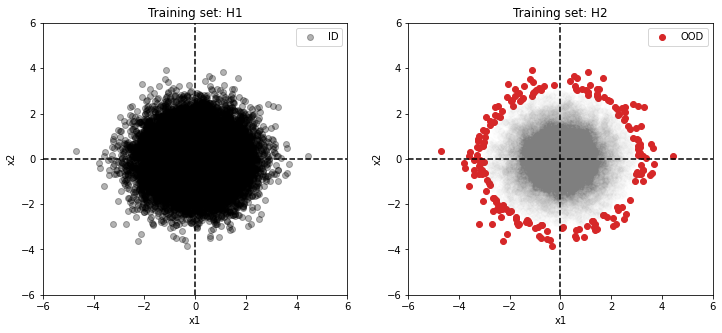

In [12]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))

axs[0].scatter(*x_h1.T, color = "black", label = "ID", alpha = 0.3)
axs[0].set_title("Training set: H1")

axs[1].scatter(*x_ood.T, color = "tab:red", label = "OOD")
axs[1].scatter(*x_id.T, color = "tab:grey", alpha = 0.01,)
axs[1].set_title("Training set: H2")

for ax in axs.ravel():
    ax.set_xlim([-6, 6])
    ax.set_ylim([-6, 6])
    ax.axvline(0, linestyle = "--", color = 'black')
    ax.axhline(0, linestyle = "--", color = 'black')
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.legend()
    
plt.show()


In [13]:
np.random.seed(13)
train_idx = np.random.choice(np.arange(x_id.shape[0]), 1000)
test_idx = np.random.choice(np.arange(x_ood.shape[0]), 200)

In [14]:
x_id_train = x_id[train_idx]
x_ood_train = x_ood[test_idx]

## Simulating time-to-events

In [15]:
y_h1, s_h1 = dgp.generate_survival_time(X = x_id_train, k = 3, weights = [0.2, 0.5, -0.1, -0.4], censoring_rate = 0.3, type = "G2")

In [16]:
y_ood, s_ood = dgp.generate_survival_time(X = x_ood_train, k = 3, weights = [0.2, 0.5, -0.1, -0.4], censoring_rate = 0.3, type = "G2")


## Creating dataset: ID & OOD

In [17]:
data_id_train = pd.read_csv("data/sim_train")

In [18]:
data_id_train = data_id_train.iloc[:, 1:]

### Split OOD dataset into training and test set

In [19]:
random_state = 13

In [20]:
data_ood_train = pd.DataFrame(
    np.column_stack([y_ood, s_ood, x_ood_train]), columns=["Duration", "Censor", "x1", "x2"]
)

In [21]:
data_ood_train.shape, data_id_train.shape

((200, 4), (1000, 4))

## Normalise the duration column

1. Remove outliers (i.e., $t_{j} \quad s.t. \quad t_{j} >= t_{(99)}$)

2. Normalise the value by min-max

This steps is necessary to avoid numerical instability of the optimisation step. 

In [22]:
def drop_high_duration(df: pd.DataFrame) -> pd.DataFrame:
    # Calculate the 99th percentile for the 'duration' column
    percentile_99 = df['Duration'].quantile(0.99)
    
    # Filter out rows where 'duration' is greater than the 99th percentile
    df_filtered = df[df['Duration'] <= percentile_99]
    
    return df_filtered

In [23]:
d1_data = drop_high_duration(data_id_train)
d2_data = drop_high_duration(data_ood_train)

In [24]:
def normalize_column(df, ref_df, column_name):
    """
    Normalize the specified column in the DataFrame to be between 0 and 1.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    ref_df (pd.DataFrame): The reference DataFrame.
    column_name (str): The column to be normalized.

    Returns:
    pd.DataFrame: The DataFrame with the normalized column.
    """
    df = df.copy()  # To avoid modifying the original DataFrame
    min_value = ref_df[column_name].min()
    max_value = ref_df[column_name].max()
    df[column_name] = (df[column_name] - min_value) / (max_value - min_value)
    df[column_name] += 1e-8
    return df

In [25]:
d1_data = normalize_column(d1_data, d1_data, "Duration")
d2_data = normalize_column(d2_data, d1_data, "Duration")

## Comparison: D1 and D2

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_duration_hist_and_cdf(d1_data: pd.DataFrame, d2_data: pd.DataFrame):
    # Extract 'Duration' columns and sort them for both datasets
    d1_duration = d1_data['Duration'].sort_values()
    d2_duration = d2_data['Duration'].sort_values()
    
    # Create subplots: 1 row, 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot the histogram on the left subplot
    ax1.hist(d1_duration, bins=30, color='red', alpha=0.4, label='D1', edgecolor='black')
    ax1.hist(d2_duration, bins=30, color='blue', alpha=0.4, label='D2', edgecolor='black')
    
    ax1.set_xlabel('Duration')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Histogram of Duration')
    ax1.legend()

    # Compute empirical CDFs
    d1_n = len(d1_duration)
    d2_n = len(d2_duration)
    
    d1_y_vals = np.arange(1, d1_n + 1) / d1_n
    d2_y_vals = np.arange(1, d2_n + 1) / d2_n
    
    # Plot the empirical CDF on the right subplot
    ax2.plot(d1_duration.values, d1_y_vals, marker='.', linestyle='none', color='red', label='D1')
    ax2.plot(d2_duration.values, d2_y_vals, marker='.', linestyle='none', color='blue', label='D2')

    ax2.set_xlabel('Duration')
    ax2.set_ylabel('Empirical CDF')
    ax2.set_title('Empirical CDF of Duration')
    ax2.legend()

    # Adjust layout for a cleaner appearance
    plt.tight_layout()

    # Show the plot
    plt.show()


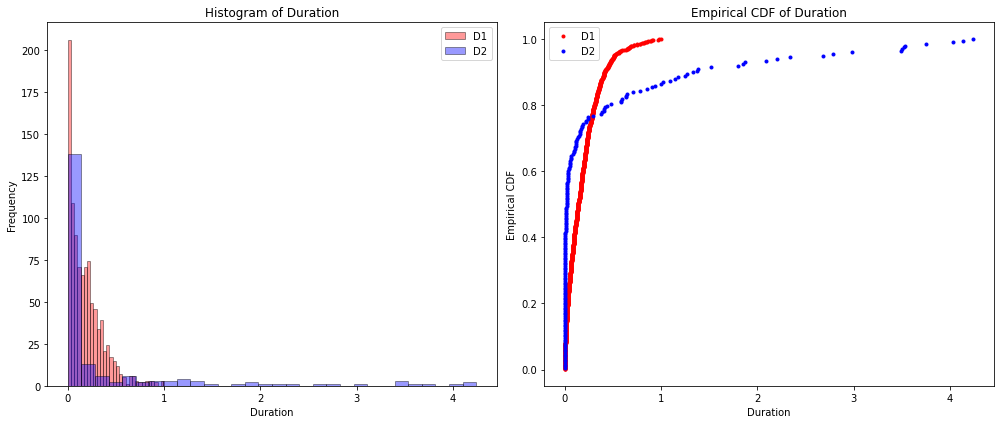

In [27]:
plot_duration_hist_and_cdf(d1_data, d2_data)


## Baseline model: AFT

In [28]:
aft = WeibullAFTFitter()
aft.fit(d1_data[[t_label] + [e_label] + x_label], duration_col="Duration", event_col="Censor", show_progress = True)

aft.print_summary(3)  # access the results using aft.summary

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.4080187055991744
            Iterations: 10
            Function evaluations: 11
            Gradient evaluations: 10
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.4080187055991744
       x: [ 6.347e-01  8.139e-01 -1.469e+00  2.694e-01]
     nit: 10
     jac: [ 6.482e-07 -1.007e-06 -1.195e-07  5.001e-07]
    nfev: 11
    njev: 10


<lifelines.WeibullAFTFitter: fitted with 990 total observations, 300 right-censored observations>
             duration col = 'Duration'
                event col = 'Censor'
   number of observations = 990
number of events observed = 690
           log-likelihood = 403.939
         time fit was run = 2024-10-10 15:02:36 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                   
lambda_ x1         0.646     1.908     0.043           0.561           0.731               1.753               2.077
        x2         0.822     2.276     0.042           0.739           0.905               2.094               2.472
        Intercept -1.469     0.230     0.029          -1.526          -1.411               0.217               0.244
rho_    Intercept  0.269     1.309     0.029           0.213           0.326               1.237               1.385

                   cmp to       z       p  -log2(p)
param   covariate                                  
lambda_ x1          0.000  14.909 <0.0005   164.569
        x2          0.000  19.419 <0.0005   276.628
        Intercept   0.000 -49.994 <0.0005       inf
rho_    Intercept   0.000   9.333 <0.0005    66.402
---
Concordance = 0.777
AIC = -799.877
log-likelihood ratio test = 363.740 on 2 df
-log2(p) of ll-ratio test = 262.383

## Evaluation (using training dataset: D1)

In [29]:
concordance_index_censored(d1_data["Censor"] == 1.0, d1_data["Duration"], -aft.predict_median(d1_data))

(0.7772862519458511, 236679, 67815, 0, 0)

## Evaluation (using test dataset: D2)

In [30]:
concordance_index_censored(d2_data["Censor"] == 1.0, d2_data["Duration"], -aft.predict_median(d2_data))

(0.7001973135007968, 9202, 3926, 49, 0)

### To check whether .predict_survival_function does what I believe it does.

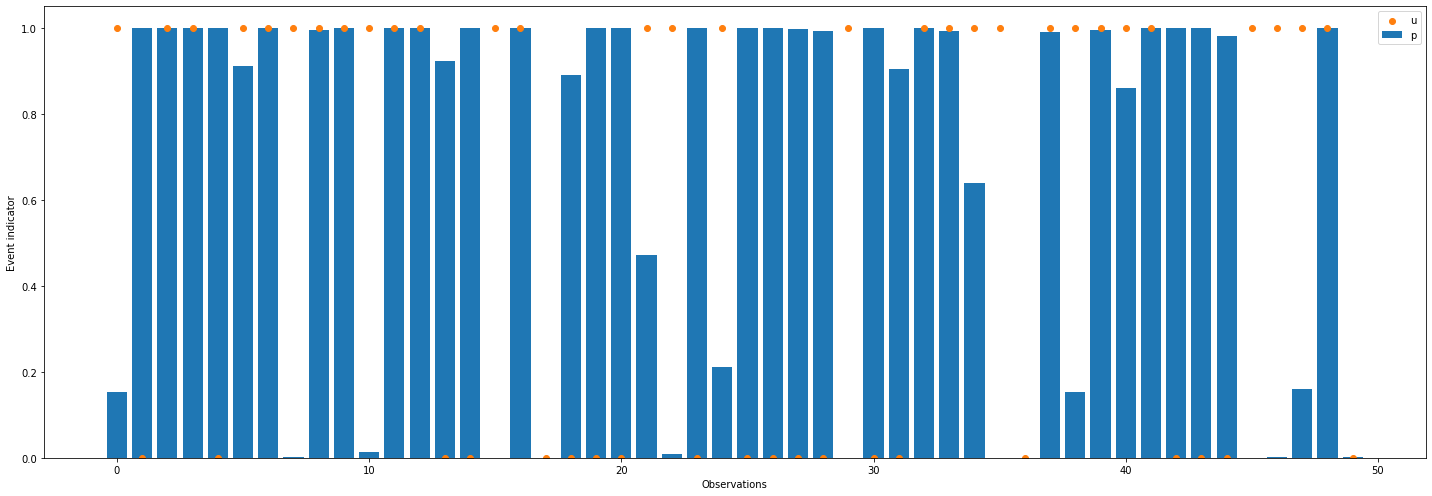

In [31]:
plt.figure(figsize=(20, 7))
plt.bar(
    np.arange(50),
    torch.diagonal(
        torch.tensor(
            aft.predict_survival_function(
                df=d2_data, times=d2_data["Duration"]
            ).values
        )
    )[:50],
    label = "Survival distribution"
)
plt.scatter(np.arange(50), d2_data["Censor"].values[:50], label = "Censored")
plt.ylabel("Event indicator")
plt.xlabel("Observations")
plt.legend("upper right")
plt.tight_layout()
plt.show()

The circle represents the event indicator, indicating whether a subject experienced the event. The bar shows the predicted survival function. The graph above demonstrates that the trained model makes reasonable predictions, as the event indicator being 1 frequently aligns with a relatively low predicted survival function.

## Define necessary UDF

In [32]:
def split_dataframe(df, train_size=0.8, val_size=0.2, random_state=None):
    """
    Splits the DataFrame into train, validation, and test sets.

    Parameters:
    df (pd.DataFrame): The DataFrame to split.
    train_size (float): Proportion of the data to be used for the training set.
    val_size (float): Proportion of the data to be used for the validation set.
    random_state (int, optional): Random seed for reproducibility.

    Returns:
    tuple: A tuple containing the train, validation, and test DataFrames.
    """
    assert train_size + val_size == 1, "Proportions must sum to 1."

    # Split the DataFrame into train and remaining sets
    df_train, df_val = train_test_split(
        df, train_size=train_size, random_state=random_state
    )

    return df_train, df_val

In [33]:
def split_df(df, x_label, t_label, e_label, o_label):
    return (
        df[x_label].values,
        df[t_label].values,
        df[e_label].values,
        df[o_label].values,
    )

In [34]:
def predict_cif( method, df ):
    x_cov = torch.tensor(df[x_label].values, dtype = torch.float32)
    t = torch.tensor(df[t_label].values, dtype = torch.float32)
    
    cif = method.predict(x_cov, t)
    
    return cif

In [35]:
def compute_timediff( model, data_loader_val, n_sample, df_type, verbose ):
    
    if df_type == "D1":
        idx_in = 1.0
        idx_ood = 0.0
    else:
        idx_in = 0.0
        idx_ood = 1.0
    

    reg_loss = 0
    for batch_idx, (x, t, k, o) in tq.tqdm(enumerate(data_loader_val)):
        argsort_t = torch.argsort(t)
        x_ = x[argsort_t, :].to(model.device)
        t_ = t[argsort_t].to(model.device)
        k_ = k[argsort_t].to(model.device)
        o_ = o[argsort_t].to(model.device)

        # Split x_ into in-distribution and out-of-distribution
        x_in = x_[o_ == idx_in]
        t_in = t_[o_ == idx_in]
        k_in = k_[o_ == idx_in]

        x_ood = x_[o_ == idx_ood]
        t_ood = t_[o_ == idx_ood]
        k_ood = k_[o_ == idx_ood]
        
        regloss = 0.0
        if x_ood.shape[0] > 0:
            _, regloss_ = model.regularisation(x=x_ood, verbose = verbose, n_sample=n_sample)
            regloss = regloss_.item()
            
        reg_loss += regloss

    return reg_loss

## coDeSurv: DeSurv with consistency constraint.

Data preparation step includes:
1. Split training data (i.e. D1 and D2) into train and validation set
2. Apply likelihood-based training w.r.t. D1 while regularising the model using the baseline based on D2.
3. Generate test set (D1 and D2) using the data generating process and use them for the final evaluation

First, we create train_data by combining the D1 and D2 generated above. Recall that we require indicator for the source of data (i.e., out-of-distribution / in-distribution) to determine which objective function to optimise depending on the source of D1 data will be used for consistency regularsation whereas the D2 data will be used for likelihood term. Note that the baseline model was trained on D2 and tested on D1. 

In [36]:
d1_data[o_label] = 0.0
d2_data[o_label] = 1.0

In [37]:
train_data = pd.concat([d1_data, d2_data], axis=0)

In [38]:
df_train, df_val = split_dataframe(train_data)

In [39]:
x_train, t_train, e_train, o_train = split_df(
    df_train, x_label, t_label, e_label, o_label
)
x_val, t_val, e_val, o_val = split_df(df_val, x_label, t_label, e_label, o_label)

In [40]:
batch_size = 128

In [41]:
dataset_train = TensorDataset(
    *[
        torch.tensor(u, dtype=dtype_)
        for u, dtype_ in [
            (x_train, torch.float32),
            (t_train, torch.float32),
            (e_train, torch.long),
            (o_train, torch.long),
        ]
    ]
)
data_loader_train = DataLoader(
    dataset_train, batch_size=batch_size, pin_memory=True, shuffle=True, drop_last=True
)

dataset_val = TensorDataset(
    *[
        torch.tensor(u, dtype=dtype_)
        for u, dtype_ in [
            (x_val, torch.float32),
            (t_val, torch.float32),
            (e_val, torch.long),
            (o_val, torch.long),
        ]
    ]
)
data_loader_val = DataLoader(
    dataset_val, batch_size=batch_size, pin_memory=True, shuffle=True
)

In this section, we train the model. During training, you might encounter error messages such as “Error occurred with tensor([0.9990]). Retrying…”. This error indicates that the numerical solver, which is required during the sampling step from the predicted survival time CDF, fails to converge because the simulated failure time is very close to 1. When this occurs, we simply re-sample the survival time from the CDF.

Note: it seems that this error can occur for the value not close to 1 as well. It would be important to investigate why this happens, and figure out how to make this operation more robust.

In [42]:
hidden_dim = 8
training = False
lr = 1e-3
n_epochs = 300

xdim = x_train.shape[1]


In [78]:
model = ConsistentDeSurv(
    lr, xdim, hidden_dim, baseline=aft, nonlinearity=nn.ReLU, device="cpu", n=15, df_columns = x_label
)
 
if training:
    model.optimize(
        data_loader_train,
        n_sample=50,
        n_epochs=n_epochs,
        logging_freq=1,
        data_loader_val=data_loader_val,
        max_wait=20,
        pretrain_epochs = 20,
        verbose=True,
    )
    torch.save(model.state_dict(), "desurv_consistent_ex05_d3_correct")
    model.eval()
else:
    state_dict = torch.load("desurv_consistent_ex05_d3_correct")
    model.load_state_dict(state_dict)
    model.eval()

CondODENet: cpu specified, cpu used


## Evaluation

1. C-index
2. Log-likelihood
3. Expected discrepancy between survival trajectories

### Prepare test set

In [79]:
test_data = pd.read_csv("data/sim_test")

In [80]:
data_id_test = test_data[test_data["OOD"] == 0.0]
data_ood_test = test_data[test_data["OOD"] == 1.0]

In [81]:
data_id_test.shape, data_ood_test.shape

((312, 6), (312, 6))

In [82]:
x_test, t_test, e_test, o_test = split_df(test_data, x_label, t_label, e_label, o_label)

dataset_test = TensorDataset(
    *[
        torch.tensor(u, dtype=dtype_)
        for u, dtype_ in [
            (x_test, torch.float32),
            (t_test, torch.float32),
            (e_test, torch.long),
            (o_test, torch.long),
        ]
    ]
)

data_loader_test = DataLoader(
    dataset_test, batch_size=batch_size, pin_memory=True, shuffle=True
)

## Quantitative Assessment

In [83]:
loss_v1_d1 = compute_timediff(model, data_loader_test, n_sample = 50, df_type = "D1", verbose = True)

0it [00:03, ?it/s]

KeyboardInterrupt



In [ ]:
print("Similarity across survival trajectories")
print("Dataset: D1")
print(f"coDeSurv: {loss_v1_d1}")

In [ ]:
loss_v1_d2 = compute_timediff(model, data_loader_test, n_sample = 50, df_type = "D2", verbose = True)

In [ ]:
print("Similarity across survival trajectories")
print("Dataset: D2")
print(f"coDeSurv: {loss_v1_d2}")

### Multiple iterations over consistency metrics

In [ ]:
from collections import defaultdict
import tqdm as tq

In [ ]:
models = {"coDeSurv_D3":defaultdict(list)}
iterations = 50

In [ ]:
for i in range(iterations):
    print(f"Iteration: {i}")
    for data_type in ["D1", "D2"]:
        
        print(f"Iteration: {i} - coDeSurv_D3 - Computing the metric on {data_type}")
        models["coDeSurv_D3"][f"consistency_{data_type}"].append(
            compute_timediff(model, data_loader_test, n_sample = 50, df_type = data_type, verbose = True)
        )


In [ ]:
for k, v in models.items():
    for key, value in v.items():
        print(f"{k} - {key}")
        print(np.round(np.mean(value[:50]), 4), np.round(np.std(value[:50]),4))


## Predictive accuracy

We first fix the dataset to be used for the evaluation. This is to ensure that we use the same dataset to compare both similarity and predictive accuracy of each model.

## Likelihood

In [84]:
lik_v1 = model.compute_lik(data_id_test[x_label].values, data_id_test[t_label].values, data_id_test[e_label].values)
lik_v1_d2 = model.compute_lik(data_ood_test[x_label].values, data_ood_test[t_label].values, data_ood_test[e_label].values)

In [85]:
print("Predictive accuracy: log-likelihood")
print("Dataset: D1")
print(f"D1: Consistent DeSurv: {lik_v1}")

Predictive accuracy: log-likelihood
Dataset: D1
D1: Consistent DeSurv: -6.2666802406311035


In [86]:
print("Predictive accuracy: log-likelihood")
print("Dataset: D2")
print(f"D1: Consistent DeSurv: {lik_v1_d2}")

Predictive accuracy: log-likelihood
Dataset: D2
D1: Consistent DeSurv: -6.317348957061768


In [87]:
aft.score(data_id_test), aft.score(data_ood_test)

(-5.726801521106306, -6.775011630512932)

## C-index

In [88]:
def compute_cidx( model_name, df ):
    res = 0
    if model_name == "baseline":
        res = concordance_index_censored(df["Censor"] == 1.0, df["Duration"], -aft.predict_median(df))
    
    elif model_name == "coDeSurv":
        res = concordance_index_censored(df["Censor"] == 1.0, 
                           df["Duration"], -predict_cif(model, df).detach().numpy())
    elif model_name == "DeSurv":
        res = concordance_index_censored( df["Censor"] == 1.0, 
                           df["Duration"], -predict_cif(model_v2, df).detach().numpy())
    else:
        res = concordance_index_censored(df["Censor"] == 1.0, 
                           df["Duration"], -predict_cif(model_v3, df).detach().numpy())
    
    return res

In [89]:
def show_cidx(model_name):
    cidx_d1, cidx_d2 = compute_cidx(model_name, data_id_test), compute_cidx(model_name, data_ood_test)
    
    print(f"{model_name}")
    print(f"D1: {cidx_d1[0]}, D2: {cidx_d2[0]} \n")

In [90]:
print("Predictive accuracy: c-index")

for model_name in ["baseline","coDeSurv"]:
    show_cidx(model_name)

Predictive accuracy: c-index
baseline
D1: 0.7871732146541307, D2: 0.6639752513534416 

coDeSurv
D1: 0.8139644551858293, D2: 0.8653982985305491 



## Qualitative Assessment: visualise the predicted survival curves across different models

In [91]:
def gather_predictions( df, method ):
    baseline_surv = aft.predict_survival_function(df, times = np.linspace(0, 2, 200))
    surv = method.predict_surv_df(torch.tensor(df[x_label].values, dtype=torch.float32).clone().detach(),
                        np.linspace(0, 2, 200))
    
    return baseline_surv, surv

def plot_surv(baseline_surv, surv, df, idx, model_name = "DeSurv"):
    
    plt.plot(surv.iloc[:, idx], label = model_name)
    plt.plot(baseline_surv.iloc[:, idx], color = 'grey', label = "Baseline")
    
#     plt.axvline(df["Duration"].iloc[idx], label = "Censor: %d" % df["Censor"].iloc[idx], color = 'black')
    plt.legend()
    plt.xlabel("Durations")
    plt.ylabel("Survival Probabilities")
    plt.show()

def plot_surv_joint(baseline_surv, joint_survs, df, idx, figsize = (8, 5)):
    
    plt.figure(figsize = figsize)
    colors = sns.color_palette("hls", len(joint_survs))
    for i, (model_name, model) in enumerate(joint_survs.items()):
        plt.plot(model.iloc[:, idx], color = colors[i], label = model_name)
    
    plt.plot(baseline_surv.iloc[:, idx], color = 'grey', label = "Baseline")
    
#     plt.axvline(df["Duration"].iloc[idx], label = "Censor: %d" % df["Censor"].iloc[idx], color = 'black')
    plt.legend()
    plt.xlabel("Durations")
    plt.ylabel("Survival Probabilities")
    plt.show()

In [92]:
d1_baseline_surv, d1_surv = gather_predictions(d1_data, model)

/Users/woojungkim/Documents/2024/Oxford/code/Continuous-Predictions/experiments/model/coDeSurv.py:198: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_ = torch.tensor(np.repeat(x_test, [t_eval.size] * x_test.shape[0], axis=0), dtype=torch.float32)


In [93]:
d1_joint_surv = {"coDeSurv": d1_surv}

In [94]:
d2_baseline_surv, d2_surv = gather_predictions(d2_data, model)

/Users/woojungkim/Documents/2024/Oxford/code/Continuous-Predictions/experiments/model/coDeSurv.py:198: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_ = torch.tensor(np.repeat(x_test, [t_eval.size] * x_test.shape[0], axis=0), dtype=torch.float32)


In [95]:
d2_joint_surv = {"coDeSurv": d2_surv}

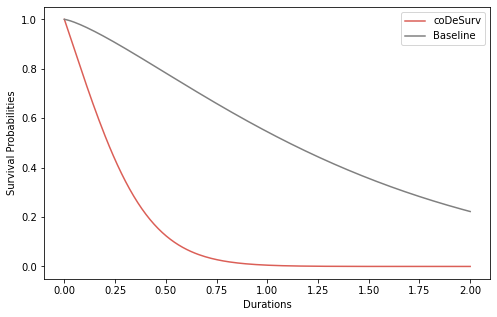

In [96]:
plot_surv_joint(d1_baseline_surv, d1_joint_surv, d1_data, 8)

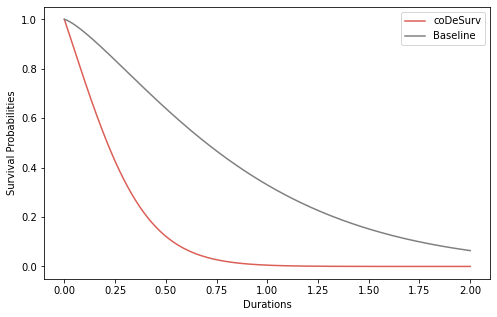

In [99]:
plot_surv_joint(d2_baseline_surv, d2_joint_surv, data_ood_test, 18)

### Save the data

In [102]:
d2_joint_surv["coDeSurv"].to_csv('data/sim_trajectory_d3.json')